### Load dataset and inspect

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('cor_vir.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 8 columns):
Sno               700 non-null int64
Date              700 non-null object
Province/State    536 non-null object
Country           700 non-null object
Last Update       700 non-null object
Confirmed         700 non-null float64
Deaths            700 non-null float64
Recovered         700 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 43.8+ KB


In [5]:
df.head()

,Sno,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020 12:00:00,Anhui,China,2020-01-22 12:00:00,1.0,0.0,0.0
1,2,01/22/2020 12:00:00,Beijing,China,2020-01-22 12:00:00,14.0,0.0,0.0
2,3,01/22/2020 12:00:00,Chongqing,China,2020-01-22 12:00:00,6.0,0.0,0.0
3,4,01/22/2020 12:00:00,Fujian,China,2020-01-22 12:00:00,1.0,0.0,0.0
4,5,01/22/2020 12:00:00,Gansu,China,2020-01-22 12:00:00,0.0,0.0,0.0


In [6]:
# drop Sno
df.drop(['Sno','Last Update'],axis=1,inplace=True)

In [7]:
# convert 'Date' to datetime object
df['Date'] = pd.to_datetime(df['Date'])

In [12]:
# focus on China right now
china = df[df['Country'].isin(['China','Mainland China'])]
china.head()

,Date,Province/State,Country,Confirmed,Deaths,Recovered
0,2020-01-22 12:00:00,Anhui,China,1.0,0.0,0.0
1,2020-01-22 12:00:00,Beijing,China,14.0,0.0,0.0
2,2020-01-22 12:00:00,Chongqing,China,6.0,0.0,0.0
3,2020-01-22 12:00:00,Fujian,China,1.0,0.0,0.0
4,2020-01-22 12:00:00,Gansu,China,0.0,0.0,0.0


In [13]:
# check duplicate
china.duplicated().sum()

0

In [16]:
# modify column for vis in Tableau
china['Province/State'] = china['Province/State'].map(lambda x: x+' Sheng')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


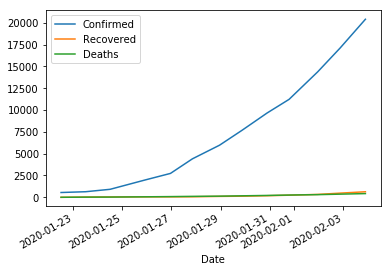

In [17]:
china.groupby(['Date']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'}).plot()

In [18]:
# calculate growth daily growth rate
# china.groupby(['Date','Province/State']).agg({'Confirmed':'sum','Deaths':'sum'})
china.groupby(['Date']).agg({'Province/State':'nunique'})

,Province/State
Date,
2020-01-22 12:00:00,34
2020-01-23 12:00:00,31
2020-01-24 12:00:00,30
2020-01-25 22:00:00,30
2020-01-26 23:00:00,30
2020-01-27 20:30:00,30
2020-01-28 23:00:00,30
2020-01-29 21:00:00,31
2020-01-30 21:30:00,31


In [19]:
full_list = list(china.groupby(['Date']).agg({'Province/State':'unique'}).iloc[0,0])

In [21]:
# fill records with full list of province
def fill_province(df):
    df.drop('Country',axis=1, inplace=True)
    # list of province appeared
    df1 = df.groupby('Date').agg({'Province/State':'unique'})
    df1['left_out'] = df1['Province/State'].map(lambda x: list(set(full_list)-set(x)))
    # create new records to append to the original df
    date_dict = dict(zip(df1.reset_index()['Date'],df1['left_out']))
    for key, value in date_dict.items():
        df = df.append(pd.DataFrame({
        'Date':key,
        'Province/State':value,
        'Confirmed':0,
        'Deaths':0,
        'Recovered':0}), ignore_index=True)
    return df

In [22]:
china_full = fill_province(china)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
res1 = china_full.groupby(['Date','Province/State']).agg(sum).reset_index().pivot_table(index='Date',columns='Province/State',values=['Confirmed','Deaths','Recovered'])


In [ ]:
draft1 = china_full.groupby(['Date','Province/State']).agg(sum).reset_index()
draft1.sum()

In [ ]:
df['Confirmed'].sum()

In [ ]:
china_full.groupby(['Date','Province/State']).agg(sum).reset_index().to_csv('draft1.csv',index=False)

In [24]:
res1

Confirmed                                             \
Province/State      Anhui Sheng Beijing Sheng Chongqing Sheng Fujian Sheng   
Date                                                                         
2020-01-22 12:00:00         1.0          14.0             6.0          1.0   
2020-01-23 12:00:00         9.0          22.0             9.0          5.0   
2020-01-24 12:00:00        15.0          36.0            27.0         10.0   
2020-01-25 22:00:00        60.0          51.0            75.0         18.0   
2020-01-26 23:00:00        70.0          68.0           110.0         35.0   
2020-01-27 20:30:00       106.0          80.0           132.0         59.0   
2020-01-28 23:00:00       152.0          91.0           147.0         82.0   
2020-01-29 21:00:00       200.0         111.0           165.0        101.0   
2020-01-30 21:30:00       237.0         121.0           206.0        101.0   
2020-01-31 19:00:00       237.0         139.0           238.0        120.0   
2020-02-01 23:00:00       340.0         183.0           262.0        159.0   
2020-02-02 21:00:00       408.0         191.0           300.0        159.0   
2020-02-03 21:40:00       480.0         212.0           337.0        179.0   

                                                                             \
Province/State      Gansu Sheng Guangdong Sheng Guangxi Sheng Guizhou Sheng   
Date                                                                          
2020-01-22 12:00:00         0.0            26.0           2.0           1.0   
2020-01-23 12:00:00         2.0            32.0           5.0           3.0   
2020-01-24 12:00:00         2.0            53.0          23.0           3.0   
2020-01-25 22:00:00         7.0            98.0          33.0           5.0   
2020-01-26 23:00:00        14.0           146.0          46.0           7.0   
2020-01-27 20:30:00        19.0           151.0          51.0           9.0   
2020-01-28 23:00:00        24.0           241.0          58.0           9.0   
2020-01-29 21:00:00        26.0           311.0          78.0          12.0   
2020-01-30 21:30:00        29.0           393.0          87.0          15.0   
2020-01-31 19:00:00        35.0           436.0          88.0          29.0   
2020-02-01 23:00:00        40.0           604.0         111.0          38.0   
2020-02-02 21:00:00        51.0           683.0         127.0          46.0   
2020-02-03 21:40:00        55.0           797.0         139.0          56.0   

                                                  ...            Recovered  \
Province/State      Hainan Sheng Hebei Sheng      ...       Shandong Sheng   
Date                                              ...                        
2020-01-22 12:00:00          4.0         1.0      ...                  0.0   
2020-01-23 12:00:00          5.0         1.0      ...                  0.0   
2020-01-24 12:00:00          8.0         2.0      ...                  0.0   
2020-01-25 22:00:00         19.0        13.0      ...                  0.0   
2020-01-26 23:00:00         22.0        18.0      ...                  0.0   
2020-01-27 20:30:00         33.0        33.0      ...                  0.0   
2020-01-28 23:00:00         43.0        48.0      ...                  0.0   
2020-01-29 21:00:00         43.0        65.0      ...                  1.0   
2020-01-30 21:30:00         50.0        82.0      ...                  2.0   
2020-01-31 19:00:00         58.0        96.0      ...                  2.0   
2020-02-01 23:00:00         63.0       104.0      ...                  5.0   
2020-02-02 21:00:00         71.0       113.0      ...                  6.0   
2020-02-03 21:40:00         79.0       126.0      ...                  7.0   

                                                                            \
Province/State      Shanghai Sheng Shanxi Sheng Sichuan Sheng Taiwan Sheng   
Date                                                                         
2020-01-22 12:00:00      

In [25]:
def calculate_gr(df, period=1):
    # calculate growth rate of a specific time period
    """
    df: dataframe of daily information
    period: time period to calculate
    """
    return ((df[period:].reset_index(drop=True)-df[:-period].reset_index(drop=True))/(df[:-period].reset_index(drop=True)))

In [59]:
daily_growth = ((res1[1:].reset_index(drop=True)-res1[:-1].reset_index(drop=True))/(res1[:-1].reset_index(drop=True)))

In [60]:
res1.to_csv('result_pivot.csv',index=False)

In [61]:
daily_growth.fillna(0,inplace=True)

In [66]:
daily_growth.stack().index.levels[1]

Index(['Anhui Sheng', 'Beijing Sheng', 'Chongqing Sheng', 'Fujian Sheng',
       'Gansu Sheng', 'Guangdong Sheng', 'Guangxi Sheng', 'Guizhou Sheng',
       'Hainan Sheng', 'Hebei Sheng', 'Heilongjiang Sheng', 'Henan Sheng',
       'Hong Kong Sheng', 'Hubei Sheng', 'Hunan Sheng', 'Inner Mongolia Sheng',
       'Jiangsu Sheng', 'Jiangxi Sheng', 'Jilin Sheng', 'Liaoning Sheng',
       'Macau Sheng', 'Ningxia Sheng', 'Qinghai Sheng', 'Shaanxi Sheng',
       'Shandong Sheng', 'Shanghai Sheng', 'Shanxi Sheng', 'Sichuan Sheng',
       'Taiwan Sheng', 'Tianjin Sheng', 'Tibet Sheng', 'Xinjiang Sheng',
       'Yunnan Sheng', 'Zhejiang Sheng'],
      dtype='object', name='Province/State')

In [71]:
new_index = pd.MultiIndex(levels=[list(res1.index),list(daily_growth.stack().index.levels[1])],labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]])
                                  

In [72]:
daily_growth.stack()

Confirmed    Deaths  Recovered
   Province/State                                      
0  Anhui Sheng            8.000000  0.000000   0.000000
   Beijing Sheng          0.571429  0.000000   0.000000
   Chongqing Sheng        0.500000  0.000000   0.000000
   Fujian Sheng           4.000000  0.000000   0.000000
   Gansu Sheng                 inf  0.000000   0.000000
   Guangdong Sheng        0.230769  0.000000        inf
   Guangxi Sheng          1.500000  0.000000   0.000000
   Guizhou Sheng          2.000000  0.000000   0.000000
   Hainan Sheng           0.250000  0.000000   0.000000
   Hebei Sheng            0.000000       inf   0.000000
   Heilongjiang Sheng          inf  0.000000   0.000000
   Henan Sheng            0.000000  0.000000   0.000000
   Hong Kong Sheng        0.000000  0.000000   0.000000
   Hubei Sheng            0.000000       inf        inf
   Hunan Sheng            1.250000  0.000000   0.000000
   Inner Mongolia Sheng   0.000000  0.000000   0.000000
   Jiangsu Sheng          4.000000  0.000000   0.000000
   Jiangxi Sheng          2.500000  0.000000   0.000000
   Jilin Sheng                 inf  0.000000   0.000000
   Liaoning Sheng         0.500000  0.000000   0.000000
   Macau Sheng           -1.000000  0.000000   0.000000
   Ningxia Sheng          0.000000  0.000000   0.000000
   Qinghai Sheng          0.000000  0.000000   0.000000
   Shaanxi Sheng               inf  0.000000   0.000000
   Shandong Sheng         2.000000  0.000000   0.000000
   Shanghai Sheng         0.777778  0.000000   0.000000
   Shanxi Sheng           0.000000  0.000000   0.000000
   Sichuan Sheng          0.600000  0.000000   0.000000
   Taiwan Sheng          -1.000000  0.000000   0.000000
   Tianjin Sheng          0.000000  0.000000   0.000000
...                            ...       ...        ...
11 Gansu Sheng            0.078431  0.000000   0.000000
   Guangdong Sheng        0.166911  0.000000   0.400000
   Guangxi Sheng          0.094488  0.000000   2.500000
   Guizhou Sheng          0.217391  0.000000   0.000000
   Hainan Sheng           0.112676  0.000000   0.000000
   Hebei Sheng            0.115044  0.000000   0.000000
   Heilongjiang Sheng     0.631579  0.000000   0.000000
   Henan Sheng            0.192580  0.000000   0.428571
   Hong Kong Sheng        0.000000  0.000000   0.000000
   Hubei Sheng            0.209806  0.182857   0.342373
   Hunan Sheng            0.138196  0.000000   0.375000
   Inner Mongolia Sheng   0.259259  0.000000   0.000000
   Jiangsu Sheng          0.136531  0.000000   0.142857
   Jiangxi Sheng          0.217391  0.000000   0.055556
   Jilin Sheng            0.354839  0.000000   0.000000
   Liaoning Sheng         0.057143  0.000000   0.000000
   Macau Sheng            0.000000  0.000000   0.000000
   Ningxia Sheng          0.214286  0.000000        inf
   Qinghai Sheng          0.363636  0.000000   0.000000
   Shaanxi Sheng          0.224138  0.000000        inf
   Shandong Sheng         0.097561  0.000000   0.166667
   Shanghai Sheng         0.077720  0.000000   0.000000
   Shanxi Sheng           0.121212  0.000000  -0.333333
   Sichuan Sheng          0.110236  0.000000   0.166667
   Taiwan Sheng           0.000000  0.000000   0.000000
   Tianjin Sheng          0.250000  0.000000   0.000000
   Tibet Sheng            0.000000  0.000000   0.000000
   Xinjiang Sheng         0.208333  0.000000   0.000000
   Yunnan Sheng           0.114286  0.000000   0.666667
   Zhejiang Sheng         0.145028  0.000000   0.333333

[408 rows x 3 columns]

In [78]:
daily_growth_mod = daily_growth.stack().reset_index(drop=True).set_index(new_index).reset_index().rename(columns={'level_0':'Date',
                                                                                           'level_1':'Province/State'})
daily_growth_mod.to_csv('daily_growth.csv',index=False)